In [16]:
import pandas as pd
# https://pandas.pydata.org/docs/

import numpy as np
# https://numpy.org/doc/stable/about.html

from math import sqrt
# https://docs.python.org/3/library/math.html
from datetime import datetime
# https://docs.python.org/3/library/datetime.html

from matplotlib import pyplot as plt
# https://matplotlib.org/index.html
import seaborn as sns
# https://seaborn.pydata.org/

from sklearn.metrics import mean_squared_error
# https://scikit-learn.org/stable/getting_started.html

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
# https://www.statsmodels.org/stable/index.html

from scipy import stats
# https://docs.scipy.org/doc/scipy/reference/
import warnings
warnings.filterwarnings('ignore')

In [17]:
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

In [18]:
#convert to time series:
n = 100 #number of observations
et = np.random.normal(size=n)

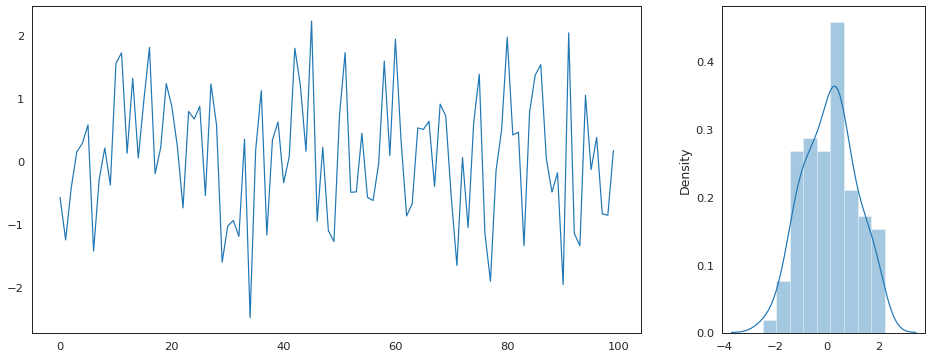

In [19]:
fig, ax = plt.subplots(1,2, figsize=(16, 6), gridspec_kw={'width_ratios':[3, 1]})

ax[0].plot(et)
sns.distplot(et, ax=ax[1])

In [ ]:

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    

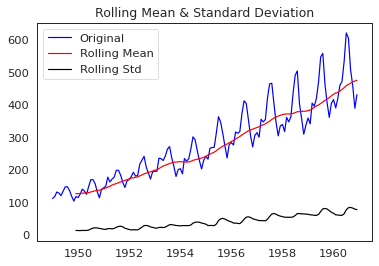

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
test_stationarity(data['#Passengers'])

This is not stationary because :

*   mean is increasing even though the std is small
*   Test stat is > critical value


4.  **MAKING THE TIME SERIES STATIONARY**

There are two major factors that make a time series non-stationary. They are:


*   **Trend**: non-constant mean
*   **Seasonality**: Variation at specific time-frames


The basic idea is to model the trend and seasonality in this series, so we can remove it and make the series stationary. Then we can go ahead and apply statistical forecasting to the stationary series. And finally we can convert the forecasted values into original by applying the trend and seasonality constrains back to those that we previously separated



**Trend**

The first step is to reduce the trend using transformation, as we can see from the previous plots that there is a strong positive trend. These transformation can be log, sq-rt, cube root etc . Basically it penalizes larger values more than the smaller. In this case we will use the logarithmic transformation

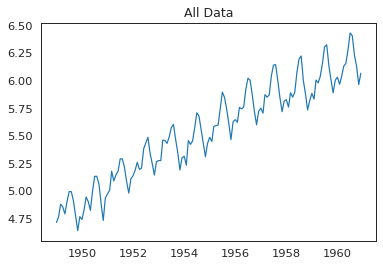

In [ ]:
all_data_log = np.log(data['#Passengers'])
train_log = np.log(df_train['W'])
test_log = np.log(df_test['W'])
plt.plot(all_data_log)
plt.title("All Data")
plt.show()



**Smoothing:** In smoothing we usually take the past few instances (rolling estimates). **Moving average** method is most common method of smoothing. In this, first take x consecutive values and this depends on the frequency if it is 1 year we take 12 values.

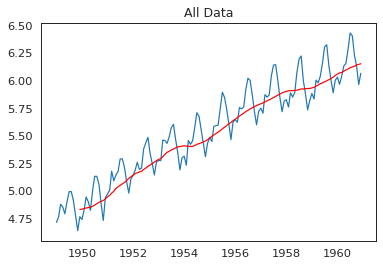

In [ ]:

moving_avg = all_data_log.rolling(window=12).mean()
plt.plot(all_data_log)
plt.title("All Data")
plt.plot(moving_avg,color='red')
plt.show()



In [ ]:
ts_log_moving_avg_diff = all_data_log - moving_avg
print(ts_log_moving_avg_diff)
ts_log_moving_avg_diff.head(24)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
                ...   
1960-08-01    0.282363
1960-09-01    0.098235
1960-10-01   -0.009230
1960-11-01   -0.182690
1960-12-01   -0.085789
Name: #Passengers, Length: 144, dtype: float64


Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
Name: #Passengers, dtype: float64

In [ ]:
# remove all NaN fields
ts_log_moving_avg_diff.dropna(inplace = True)
ts_log_moving_avg_diff.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #Passengers, dtype: float64

Let's check for stationarity

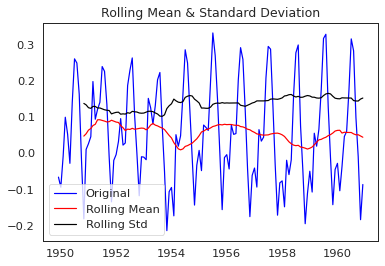

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [ ]:
# plot original vs rolling mean vs rolling standard deviation of the difference obtained above
test_stationarity(ts_log_moving_avg_diff)

Here, we notice two things:

*   The rolling values are varying slightly but there is no specific trend
*   The test statistics is smaller than the 5 % critical values. That tells us that we are 95% confident that this series is stationary



**Seasonality (along with Trend)**
Most Time series have trends along with seasonality. There are two common methods to remove trend and seasonality, they are:


*  **Differencing**: by taking difference using time lag
*   **Decomposition**: model both trend and seasonality, then remove them



**Differencing**:


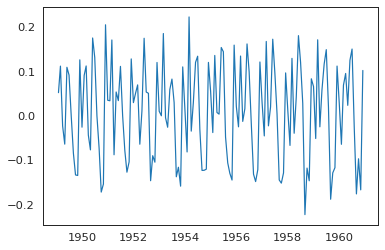

In [ ]:
#Differencing of logarithm of data
ts_log_diff = all_data_log - all_data_log.shift()
plt.plot(ts_log_diff)

Let’s  check stationarity 

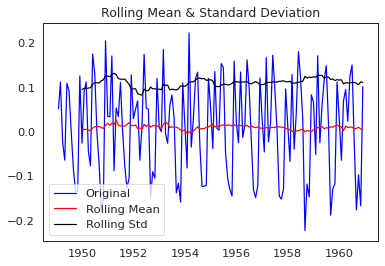

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
#remove Nan from obtained differenced series 
# and plot the original versus rolling mean verss rolling standard deviation
ts_log_diff.dropna(inplace = True)
test_stationarity(ts_log_diff)

It is stationary because:

*   the mean and std variations have small variations with time
*   test statistic is less than 10% of the critical values, so we can be 90 % confident that this is stationary



**Decomposing**:
Here we model both the trend and the seasonality, then the remaining part of the time series is returned

In [ ]:
#polpulate the index column
no_ALL_Data = len(all_data_log)
print(no_ALL_Data)
indexCol = []
for i in range (no_ALL_Data):
    indexCol.append(i+1)
df_All_Data = pd.DataFrame()
df_All_Data['0'] = indexCol
df_All_Data['W'] = data['#Passengers'][:no_ALL_Data]

144


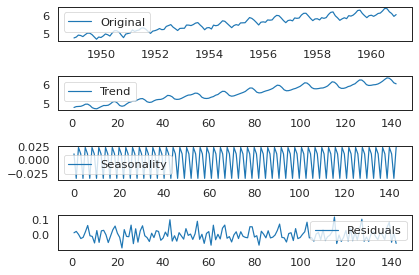

In [ ]:
#Decomposition of logarithm of data into trend, seasonality and residuals


decomposed = seasonal_decompose(np.asarray(all_data_log), freq=3)

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.subplot(411)
plt.plot(all_data_log, label = 'Original')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()


In [ ]:
# divide the differenced series into train and test
df_train['W_diff'] = ts_log_diff[0:no_of_train]
df_test['W_diff'] = ts_log_diff[no_of_train:]
data['W_diff'] = ts_log_diff

Remove the trend and seasonality from the Time series and now we can use the residual values. Let’s check stationarity.

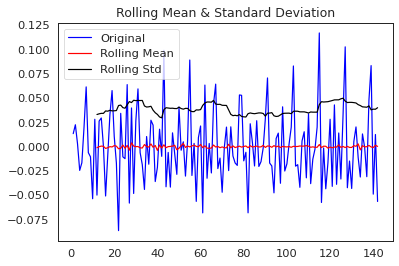

Results of Dickey-Fuller Test:
Test Statistic                -8.397413e+00
p-value                        2.279195e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [ ]:
#Store the residual series and plot it's rolling mean and rolling standard deviation
df_temp = pd.DataFrame()
df_temp['W'] = residual
df_temp['W'].dropna(inplace = True)
ts_log_decompose = df_temp['W']
test_stationarity(ts_log_decompose)

This is stationary because:

*   test statistic is lower than 1% critical values
*   the mean and std variations have small variations with time



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt
from numpy import mean
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import pandas as pd
import statsmodels
import numpy as np
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
import statsmodels.api
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pyplot import figure
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.arima_model import ARMA

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
from datetime import datetime


In [ ]:

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AirPassengers.csv')

In [ ]:
data['W_diff'] = ts_log_diff
data['W_diff'].dropna(inplace=True)
normalized = data['W_diff'].values
normalized1d=[]
for i in range(1,len(normalized)):
    normalized1d.append(normalized[i])

# Correlation, Autocorrelation (ACF), Partial autocorrelation (PACF) 

**Autocorrelation (ACF):**

Just as correlation measures the extent of a linear relationship between two variables, autocorrelation measures the linear relationship between lagged values of a time series.

There are several autocorrelation coefficients, corresponding to each panel in the lag plot. For example, $r_1$ measures the relationship between $y_t$ and $y_{t−1}$, $r_2$ measures the relationship between $y_t$ and $y_{t−2}$, and so on.


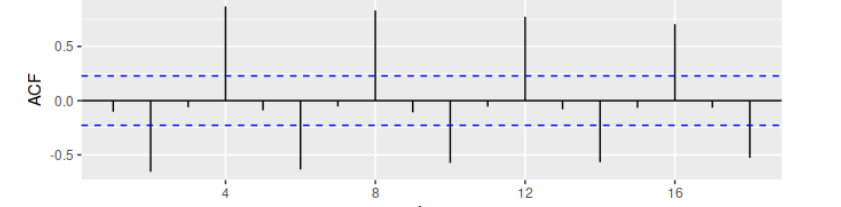





**PACF**


 > Partial Autocorrelation is finding the correlation between present$(x_t)$ and random lags value $(x_{t-h})$. Hence, the correlation in the middle values like $(x_{t-1}), (x_{t-2}), (x_{t-3}) ... (x_{t-(h-1)})$ will not be taken into account.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


temperature_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/daily-Minimum-temperature.csv', header=0, index_col=0)

rob_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/monthly-robberies.csv', header=0, index_col=0)

water_usage_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/yearly-water-usage.csv', header=0, index_col=0)


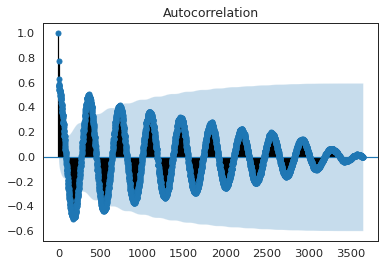

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(temperature_df, lags=len(temperature_df)-1)
plt.show()

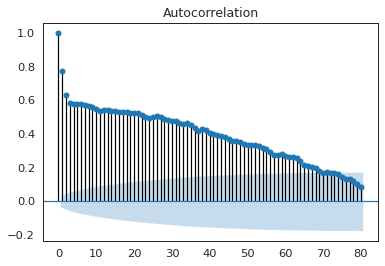

In [ ]:
plot_acf(temperature_df, lags=80)
plt.show()

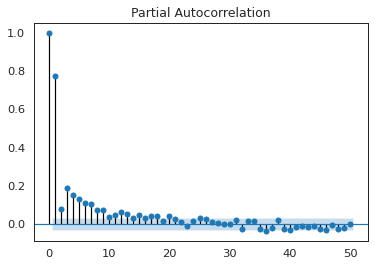

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(temperature_df, lags=50)
pyplot.show()

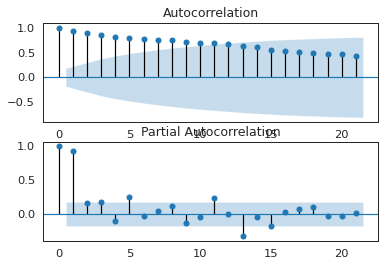

In [ ]:
# ACF and PACF on robbery dataset
pyplot.figure()
pyplot.subplot(211)
plot_acf(rob_df, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(rob_df, ax=pyplot.gca())
pyplot.show()

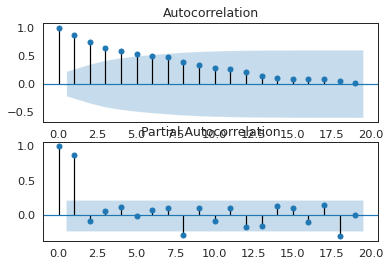

In [ ]:
# ACF and PACF on the water usage dataset
pyplot.figure()
pyplot.subplot(211)
plot_acf(water_usage_df, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(water_usage_df, ax=pyplot.gca())
pyplot.show()

**Interpretation (Trend and seasonality in ACF plots**)
>When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.

>When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.

>When data are both trended and seasonal, you see a combination of these effects.

**PACF Interpretation**

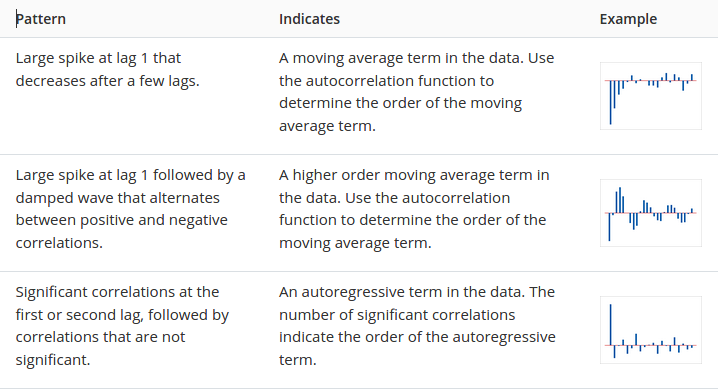

# **Forecasting a time series**



Auto Regressive Integrated Moving Average(ARIMA) — It is like a liner regression equation where the predictors depend on parameters (p,d,q) of the ARIMA model 

Where,


*   p : This is the number of AR (Auto-Regressive) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3)
*   q : This is the number of MA (Moving-Average) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3)
* d :This is the number of differences or the number of non-seasonal differences




/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


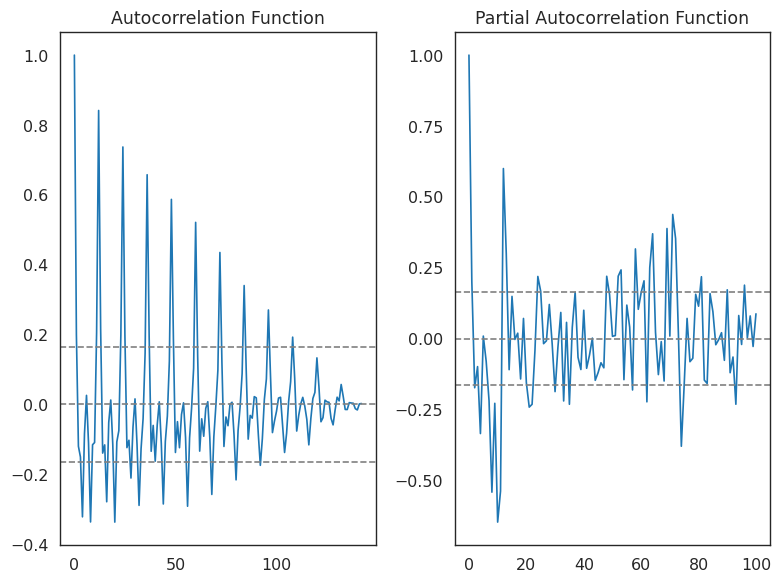

In [ ]:
#ACF and  PACF plots of differenced series
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')


lag_acf = acf(ts_log_diff, nlags = 200)
lag_pacf = pacf(ts_log_diff, nlags = 100, method = 'ols')

#plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


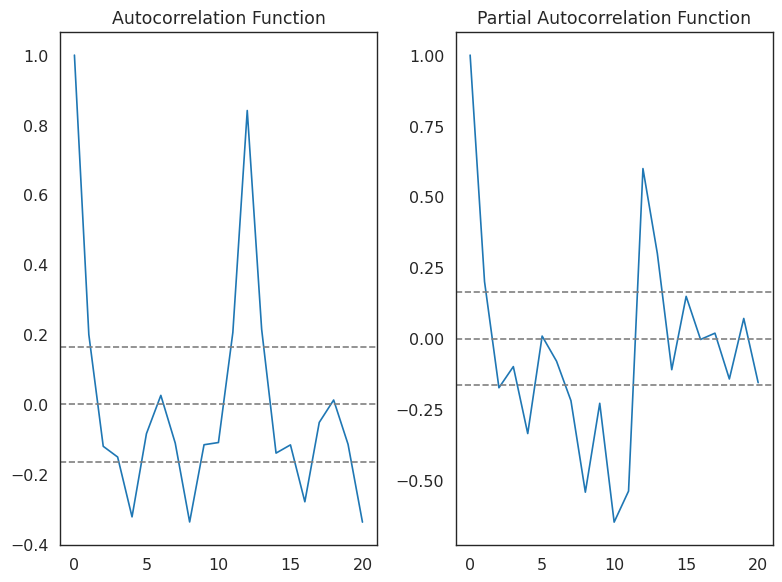

In [ ]:
#ACF and  PACF plots of differenced series
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')


lag_acf = acf(ts_log_diff, nlags = 20)
lag_pacf = pacf(ts_log_diff, nlags = 20, method = 'ols')

#plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
#AR


from statsmodels.tsa.arima_model import ARIMA as ARIMAResults

size = int(len(ts_log_diff) - 24)
train, test = ts_log_diff[0:size], ts_log_diff[size:len(ts_log_diff)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=-1, maxlag=30, method='css', trend='nc')
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    


In [ ]:
temp = []
for i in range(len(predictions)):
    temp.append(predictions[i][0])
predictions_inverse = np.exp(np.array(temp))
start_test_no = len(all_data_log) - len(predictions_inverse) - 1
inversed_test = np.array(np.exp(all_data_log[start_test_no+1:]))
inversed_pred = np.array(np.exp(all_data_log[start_test_no:len(all_data_log)-1])+ predictions_inverse)

In [ ]:
for k in range(len(inversed_test)):
    print('counter=%f, predicted=%f, expected=%f' % (k+1, inversed_pred[k], inversed_test[k]))

error = sqrt(mean_squared_error(inversed_test, inversed_pred))
print('Test RMSE: %.3f' % error)

counter=1.000000, predicted=338.000665, expected=360.000000
counter=2.000000, predicted=361.000281, expected=342.000000
counter=3.000000, predicted=343.000446, expected=406.000000
counter=4.000000, predicted=407.127249, expected=396.000000
counter=5.000000, predicted=396.985376, expected=420.000000
counter=6.000000, predicted=421.089397, expected=472.000000
counter=7.000000, predicted=473.067820, expected=548.000000
counter=8.000000, predicted=549.124652, expected=559.000000
counter=9.000000, predicted=560.066025, expected=463.000000
counter=10.000000, predicted=463.939029, expected=407.000000
counter=11.000000, predicted=407.915854, expected=362.000000
counter=12.000000, predicted=362.869211, expected=405.000000
counter=13.000000, predicted=406.018416, expected=417.000000
counter=14.000000, predicted=417.993048, expected=391.000000
counter=15.000000, predicted=391.997747, expected=419.000000
counter=16.000000, predicted=420.046142, expected=461.000000
counter=17.000000, predicted=462.

Text(0, 0.5, 'W')

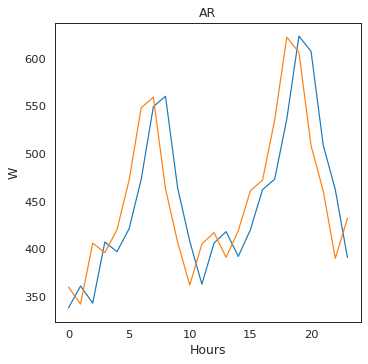

In [ ]:
# Plot the curves
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)

plt.plot(inversed_pred)
plt.plot(inversed_test)

axarr.set_title('AR')
plt.xlabel('Hours')
plt.ylabel('W')

In [ ]:
#MA

size = int(len(ts_log_diff) - 24)
train, test = ts_log_diff[0:size], ts_log_diff[size:len(ts_log_diff)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit(disp=0, maxlag=30, method='css', trend='nc')
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)


In [ ]:
temp = []
for i in range(len(predictions)):
    temp.append(predictions[i])
predictions_inverse = np.exp(np.array(temp))
start_test_no = len(all_data_log) - len(predictions_inverse) - 1
inverse_test = np.array(np.exp(all_data_log[start_test_no+1:]))

inverse_pred = np.array(np.exp(all_data_log[start_test_no:len(all_data_log)-1])+ predictions_inverse.flatten())

Text(0, 0.5, 'W')

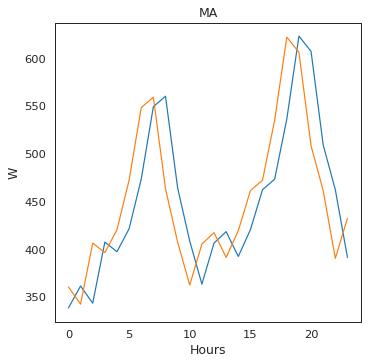

In [ ]:
# Plot the curves
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)

plt.plot(inverse_pred)
plt.plot(inverse_test)

axarr.set_title('MA')
plt.xlabel('Hours')
plt.ylabel('W')

In [ ]:
# ARMA 
size = int(len(ts_log_diff) - 24)
train, test = ts_log_diff[0:size], ts_log_diff[size:len(ts_log_diff)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARMA(history, order=(2,0,2))
    model_fit = model.fit(disp=0, maxlag=30, method='css', trend='nc')
    output = model_fit.predict(len(history),len(history))
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)


In [ ]:
temp = []
for i in range(len(predictions)):
    temp.append(predictions[i])
predictions_inverse = np.exp(np.array(temp))
start_test_no = len(all_data_log) - len(predictions_inverse) - 1
inverse_test = np.array(np.exp(all_data_log[start_test_no+1:]))
inverse_pred = np.array(np.exp(all_data_log[start_test_no:len(all_data_log)-1])+ predictions_inverse)

In [ ]:
for k in range(len(inverse_test)):
    print('counter=%f, predicted=%f, expected=%f' % (k+1, inverse_pred[k], inverse_test[k]))

error = sqrt(mean_squared_error(inverse_test, inverse_pred))
print('Test RMSE: %.3f' % error)

counter=1.000000, predicted=338.045120, expected=360.000000
counter=2.000000, predicted=360.999837, expected=342.000000
counter=3.000000, predicted=342.977020, expected=406.000000
counter=4.000000, predicted=407.045893, expected=396.000000
counter=5.000000, predicted=396.967243, expected=420.000000
counter=6.000000, predicted=421.015551, expected=472.000000
counter=7.000000, predicted=473.014588, expected=548.000000
counter=8.000000, predicted=549.014230, expected=559.000000
counter=9.000000, predicted=559.981854, expected=463.000000
counter=10.000000, predicted=463.957135, expected=407.000000
counter=11.000000, predicted=408.003363, expected=362.000000
counter=12.000000, predicted=362.993016, expected=405.000000
counter=13.000000, predicted=406.046089, expected=417.000000
counter=14.000000, predicted=417.988020, expected=391.000000
counter=15.000000, predicted=391.980754, expected=419.000000
counter=16.000000, predicted=420.026360, expected=461.000000
counter=17.000000, predicted=462.

Text(0, 0.5, 'W')

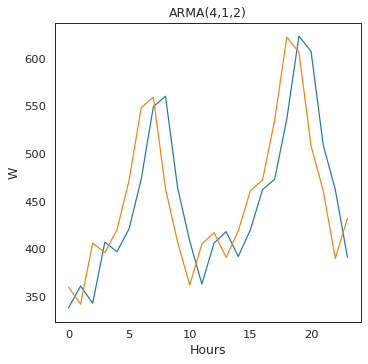

In [ ]:
# Plot the curves
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)

plt.plot(inverse_pred)
plt.plot(inverse_test)

axarr.set_title('ARMA(4,1,2)')
plt.xlabel('Hours')
plt.ylabel('W')

In [ ]:
#ARIMA
size = int(len(ts_log_diff) - 24)
train, test = ts_log_diff[0:size], ts_log_diff[size:len(ts_log_diff)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0, maxlag=30, method='css', trend='nc')
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)


In [ ]:
temp = []
for i in range(len(predictions)):
    temp.append(predictions[i])
predictions_inverse = np.exp(np.array(temp))
start_test_no = len(all_data_log) - len(predictions_inverse) - 1
inverse_test = np.array(np.exp(all_data_log[start_test_no+1:]))
inverse_pred = np.array(np.exp(all_data_log[start_test_no:len(all_data_log)-1])+ predictions_inverse.flatten())

In [ ]:
for k in range(len(inverse_test)):
    print('counter=%f, predicted=%f, expected=%f' % (k+1, inverse_pred[k], inverse_test[k]))

error = sqrt(mean_squared_error(inverse_test, inverse_pred))
print('Test RMSE: %.3f' % error)

counter=1.000000, predicted=338.067815, expected=360.000000
counter=2.000000, predicted=360.990989, expected=342.000000
counter=3.000000, predicted=343.005817, expected=406.000000
counter=4.000000, predicted=407.065698, expected=396.000000
counter=5.000000, predicted=396.967440, expected=420.000000
counter=6.000000, predicted=421.062869, expected=472.000000
counter=7.000000, predicted=473.011729, expected=548.000000
counter=8.000000, predicted=549.055135, expected=559.000000
counter=9.000000, predicted=559.990330, expected=463.000000
counter=10.000000, predicted=463.979748, expected=407.000000
counter=11.000000, predicted=408.006202, expected=362.000000
counter=12.000000, predicted=362.984763, expected=405.000000
counter=13.000000, predicted=406.068639, expected=417.000000
counter=14.000000, predicted=417.984327, expected=391.000000
counter=15.000000, predicted=392.014467, expected=419.000000
counter=16.000000, predicted=420.034392, expected=461.000000
counter=17.000000, predicted=462.

Text(0, 0.5, 'W')

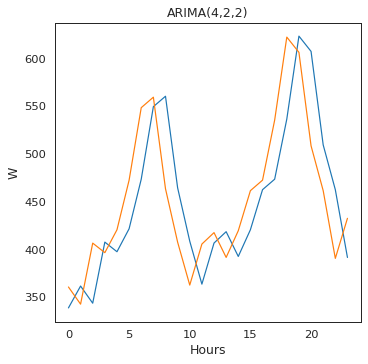

In [ ]:
# Plot the curves
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)

plt.plot(inverse_pred)
plt.plot(inverse_test)
axarr.set_title('ARIMA(4,2,2)')
plt.xlabel('Hours')
plt.ylabel('W')

END OF SESSION

In [ ]:
# Optimize ARIMA parameters
aicVal=[]
for d in range(1,5):
    for ari in range(0, 5):
        for maj in range(0,5):
            try:
                arima_obj = ARIMA(ts_log_diff, order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit(maxlag=30, method='css', trend='nc')  
                if(len(aicVal)==0):
                    aicVal.append([ari, d, maj, arima_obj_fit.aic])
                elif(aicVal[len(aicVal)-1][3]>arima_obj_fit.aic):
                    aicVal.append([ari, d, maj, arima_obj_fit.aic])
                
                print(ari, d, maj, arima_obj_fit.aic)
            except ValueError:
                pass

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-

0 1 1 -222.8063042028889
0 1 2 -229.8447721260278
0 1 3 -231.0551156250267
1 1 0 -173.7657904295104
2 1 0 -183.34735928634217
2 1 1 -223.39500377974065
2 1 2 -229.47801271892172
3 1 0 -180.3400953253224
3 1 1 -220.51753249081753


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-

3 1 2 -220.92611940928134
4 1 0 -198.91679762459222
4 1 1 -220.30044182017667
4 1 2 -227.10259876180243


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-

4 1 4 -264.39282752855536
0 2 1 -153.09776819319285
1 2 0 -76.05395234523039
2 2 0 -114.13704773423581


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-

3 2 0 -114.9265469704959
4 2 0 -128.94551712112684


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-

4 2 2 -213.54546809277258


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
#ARIMA
listLen=len(aicVal)
ar=int(aicVal[listLen-1][0])
d=int(aicVal[listLen-1][1])
ma=int(aicVal[listLen-1][2])
aic=int(aicVal[listLen-1][3])
print("smallest aic val=%f, ar=%f, d=%f, ma=%f " %(aic, ar, d, ma))

from statsmodels.tsa.arima_model import ARIMA as ARIMAResults

size = int(len(ts_log_diff) - 24)
train, test = ts_log_diff[0:size], ts_log_diff[size:len(ts_log_diff)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(ar,d,ma))
    model_fit = model.fit(disp=0, maxlag=30, method='css', trend='nc')
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)


smallest aic val=-264.000000, ar=4.000000, d=1.000000, ma=4.000000 


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:

temp = []
for i in range(len(predictions)):
    temp.append(predictions[i])
predictions_inverse = np.exp(np.array(temp))
start_test_no = len(all_data_log) - len(predictions_inverse) - 1
inverse_test = np.array(np.exp(all_data_log[start_test_no+1:]))
inverse_pred = np.array(np.exp(all_data_log[start_test_no:len(all_data_log)-1])+ predictions_inverse.flatten())

In [ ]:

for k in range(len(inverse_test)):
    print('counter=%f, predicted=%f, expected=%f' % (k+1, inverse_pred[k], inverse_test[k]))

error = sqrt(mean_squared_error(inverse_test, inverse_pred))
print('Test RMSE: %.3f' % error)

counter=1.000000, predicted=338.060169, expected=360.000000
counter=2.000000, predicted=361.035357, expected=342.000000
counter=3.000000, predicted=343.076625, expected=406.000000
counter=4.000000, predicted=407.018856, expected=396.000000
counter=5.000000, predicted=396.947140, expected=420.000000
counter=6.000000, predicted=421.070603, expected=472.000000
counter=7.000000, predicted=472.958631, expected=548.000000
counter=8.000000, predicted=548.959896, expected=559.000000
counter=9.000000, predicted=560.000430, expected=463.000000
counter=10.000000, predicted=463.881887, expected=407.000000
counter=11.000000, predicted=407.957169, expected=362.000000
counter=12.000000, predicted=363.070313, expected=405.000000
counter=13.000000, predicted=406.060838, expected=417.000000
counter=14.000000, predicted=418.012387, expected=391.000000
counter=15.000000, predicted=392.067586, expected=419.000000
counter=16.000000, predicted=420.017564, expected=461.000000
counter=17.000000, predicted=462.

Text(0, 0.5, 'W')

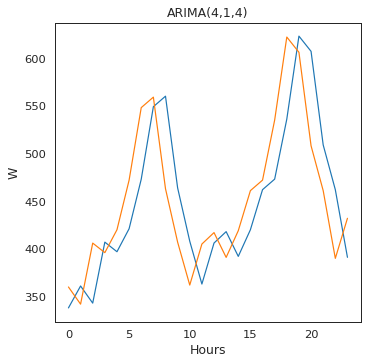

In [ ]:
# Plot the curves
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)

plt.plot(inverse_pred)
plt.plot(inverse_test)
axarr.set_title('ARIMA(4,1,4)')
plt.xlabel('Hours')
plt.ylabel('W')

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from numpy import array

import pandas as pd
# https://pandas.pydata.org/docs/

import numpy as np
# https://numpy.org/doc/stable/about.html

from math import sqrt
# https://docs.python.org/3/library/math.html
from datetime import datetime
# https://docs.python.org/3/library/datetime.html

from matplotlib import pyplot as plt
# https://matplotlib.org/index.html
import seaborn as sns
# https://seaborn.pydata.org/

from sklearn.metrics import mean_squared_error
# https://scikit-learn.org/stable/getting_started.html

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
# https://www.statsmodels.org/stable/index.html

from scipy import stats
# https://docs.scipy.org/doc/scipy/reference/

from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pip install pandas matplotlib numpy cython

In [ ]:
pip install pystan

In [ ]:
pip install fbprophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AirPassengers.csv')

In [ ]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [ ]:
data['Month'] = pd.DatetimeIndex(data['Month'])
data.dtypes

Month          datetime64[ns]
#Passengers             int64
dtype: object

In [ ]:
data = data.rename(columns={'Month': 'ds', '#Passengers': 'y'})

data.head(5)

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


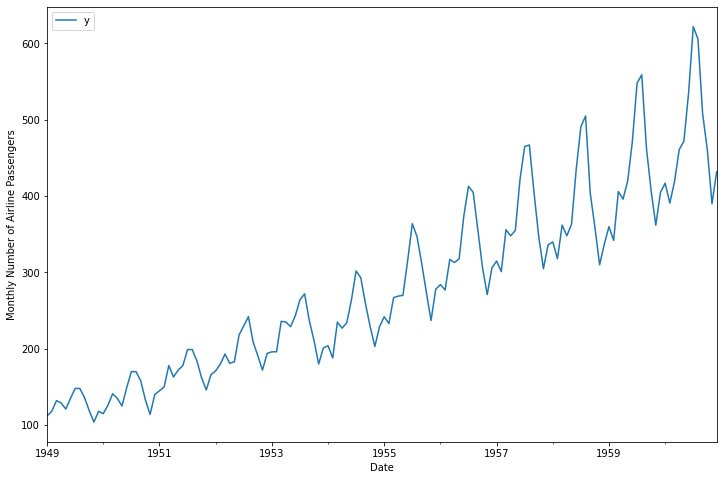

In [ ]:
ax = data.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')

plt.show()

In [ ]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)

In [ ]:
print(len(data))

144


In [ ]:
trainLen = 108
train = data[:trainLen]
test = data[trainLen:]

In [ ]:
train

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
103,1957-08-01,467
104,1957-09-01,404
105,1957-10-01,347
106,1957-11-01,305


In [ ]:
my_model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_dates = my_model.make_future_dataframe(periods=36, freq='MS')
future_dates.tail()

,ds
139,1960-08-01
140,1960-09-01
141,1960-10-01
142,1960-11-01
143,1960-12-01


In [ ]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
139,1960-08-01,547.658966,518.443411,578.870728
140,1960-09-01,510.633022,479.296416,542.333298
141,1960-10-01,479.791329,448.843695,508.499466
142,1960-11-01,454.492927,424.657712,484.909185
143,1960-12-01,481.347643,450.655567,510.611998


In [ ]:
predicted = forecast['yhat'][108:]

In [ ]:
error = sqrt(mean_squared_error(test['y'], predicted))
print('Test RMSE: %.3f' % error)

Test RMSE: 44.606


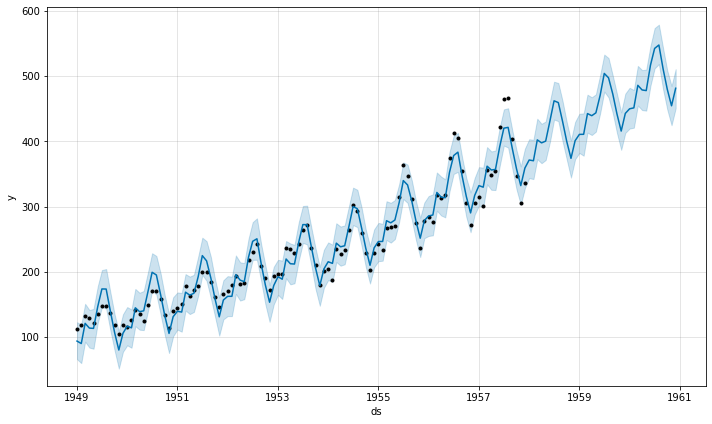

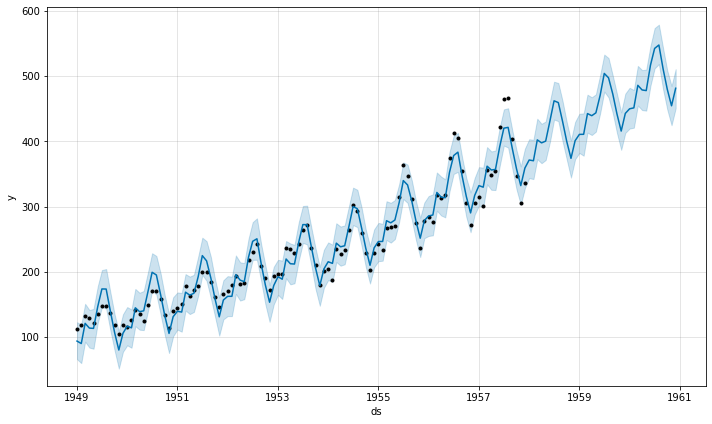

In [ ]:
my_model.plot(forecast, uncertainty=True)

# **Vanila LSTM**

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
data['#Passengers']

KeyError: ignored

In [ ]:
raw_seq = data['#Passengers']
trainLen = 111
train = raw_seq[:trainLen]
test = raw_seq[trainLen:]

KeyError: ignored

In [ ]:
# choose a number of time steps
n_steps = 3

In [ ]:
# split into samples
X, y = split_sequence(train, n_steps)

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [ ]:
test = test.reset_index(drop = True)

In [ ]:
# demonstrate prediction
X_test, y_test = split_sequence(test, n_steps)
X_test = np.array(X_test).reshape((-1, n_steps, n_features))
yhat = model.predict(X_test, verbose=0)

In [ ]:
error = sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % error)

# **Stacked LSTM**

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [ ]:
# demonstrate prediction
X_test, y_test = split_sequence(test, n_steps)
X_test = np.array(X_test).reshape((-1, n_steps, n_features))
yhat = model.predict(X_test, verbose=0)

In [ ]:
error = sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % error)

# Bidirectional LSTM

In [ ]:
from keras.layers import Bidirectional

In [ ]:
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [ ]:
# demonstrate prediction
X_test, y_test = split_sequence(test, n_steps)
X_test = np.array(X_test).reshape((-1, n_steps, n_features))
yhat = model.predict(X_test, verbose=0)

In [ ]:
error = sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % error)